In this Jupyter Notebook, we demonstrate why the implementation of Graph Locally Linear Embedding in the Python package nxt-gem (available here: https://pypi.org/project/nxt-gem/) is not quite correct. We analyze the code in nxt-gem and provide an example.. 

In fact, when implementing Locally Linear Embedding, the eigenvalues should be ordered. Subsequently, we select the eigenvectors corresponding to the smallest eigenvalues. However, in nxt-gem, the eigenvalues were not ordered. Consequently, the embedding result was not entirely accurate.

Furthermore, we provide the following example. Inspired by the paper 'Community detection in networks using graph embeddings' (by Tandon et al., available here: https://doi.org/10.1016/j.procs.2020.06.044), we will initially implement Locally Linear Embedding for the LFR benchmark graph. Subsequently, we will perform data clustering on the embedded data points using $k$-means. If the initial embedding result is correct, we should obtain a community structure similar to the ground-truth (intrinsic) community structure of the LFR benchmark graph.

In [1]:
### Using networkx package, we generate LFR_benchmark_graph with the folllwing parameters
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph

n = 200
tau1 = 3  # Power-law exponent for the degree distribution
tau2 = 1.5 # Power-law exponent for the community size distribution 
            #Should be >1
mu = 0.2 # Mixing parameter
avg_deg = 25 # Average Degree
max_deg = 60 # Max Degree
min_commu = 30 # Min Community Size
max_commu = 60 # Max Community Size


G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=avg_deg, max_degree=max_deg, min_community=min_commu, max_community=max_commu, 
    seed=2
)

pos = nx.spring_layout(G)

G = nx.Graph(G) # Remove multi-edges

selfloop_edges = list(nx.selfloop_edges(G)) # a list of self loops

G.remove_edges_from(selfloop_edges) # Remove self-loops

### LFR benchmark has ground-truth(intrinsic) community structure, we get this structure and store it in a dict.
intrinsic_communities = {frozenset(G.nodes[v]["community"]) for v in G}
intrinsic_membership = {}
for node in range(G.number_of_nodes()):
    for index, inner_set in enumerate(intrinsic_communities):
        if node in inner_set:
            intrinsic_membership[node] = index
            break

# We also store the community dict in list and clustering forms.
intrinsic_list = list(intrinsic_membership.values())
from clusim.clustering import Clustering
intrinsic_clustering = Clustering(elm2clu_dict={i: [intrinsic_membership[i]] for i in intrinsic_membership.keys()})

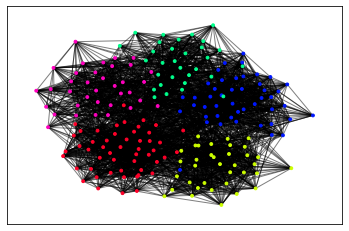

There are 5 communities in the LFR benchmark graph generated above.


In [2]:
### We plot the ground-truth (intrinsic) community structure of the LFR benchmark graph.
import matplotlib
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,
                      pos,
                      node_size=8,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=intrinsic_list
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
print(f"There are {len(set(intrinsic_list))} communities in the LFR benchmark graph generated above.")

In the following cell, we apply our correct Locally Linear Embedding (LLE) implementation coupled with $k$-means. We utilize two types of $k$-means algorithms—Euclidean $k$-means and spherical $k$-means—to generate two community structures. Interested readers may refer to the paper 'Community detection in networks using graph embeddings' by Tandon and his coauthors for further details (available here: https://doi.org/10.1016/j.procs.2020.06.044).

After obtaining community structures based on LLE and $k$-means, we compare the ground-truth community structure with the two community structures derived from LLE and $k$-means. We employ Normalized Mutual Information and element-centric similarity scores to measure community similarity.

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/11 22:46:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/11 22:46:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


This is the community structure obtained using our LLE and Euculidean k-means:


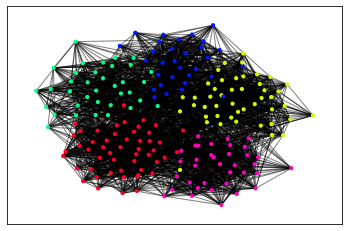

This is the community structure obtained using our LLE and spherical k-means:


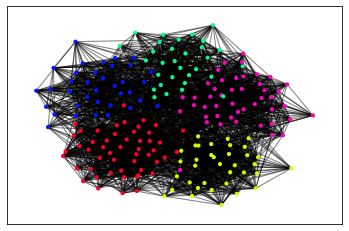

The NMI scores between the ground-truth community strucure and the community structure by our LLE with Euclidean k-means: 1.0
The NMI scores between the ground-truth community strucure and the community structure by our LLE with spherical k-means: 1.0
The ECS scores between the ground-truth community strucure and the community structure by our LLE with Euclidean k-means: 1.0
The ECS scores between the ground-truth community strucure and the community structure by our LLE with spherical k-means: 1.0


In [3]:
### Our LLE method
from LLE_Cupy import lle_cupy as lle
D = 5 # This is the embedding dimension
lle_embd = lle(G, D)


### import my package for clustering evaluation, compared to the instrinsic community structure
from evaluate_embedding import evaluate_embedding as EE

import networkx as nx

from networkx.generators.community import LFR_benchmark_graph

import matplotlib
import matplotlib.pyplot as plt

from pyspark.ml.clustering import KMeans

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors


from sklearn.metrics import normalized_mutual_info_score
from clusim.clustering import Clustering
import clusim.sim as sim

lle_vec = [Vectors.dense(row) for row in lle_embd]
lle_prep = SparkSession.builder.getOrCreate().\
                createDataFrame([(vector,) for vector in lle_vec], ["embd"])

euclid_kmeans = KMeans(k=len(set(intrinsic_list)), featuresCol="embd")
cosine_kmeans = KMeans(k=len(set(intrinsic_list)), featuresCol="embd", distanceMeasure="cosine")
lle_euclid_model = euclid_kmeans.fit(lle_prep)
lle_cosine_model = cosine_kmeans.fit(lle_prep)

# Add the cluster assignment to the DataFrame
lle_euclid = lle_euclid_model.transform(lle_prep)
lle_cosine = lle_cosine_model.transform(lle_prep)

# Extract the cluster assignment and convert it to a list
lle_euclid_membership = lle_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
lle_cosine_membership = lle_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()

print("This is the community structure obtained using our LLE and Euculidean k-means:")
nx.draw_networkx_nodes(G,
              pos,
              #louvain_membership.keys(),
              node_size=10,
              cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
              node_color=list(lle_euclid_membership)
              )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
print("This is the community structure obtained using our LLE and spherical k-means:")
nx.draw_networkx_nodes(G,
        pos,
        #louvain_membership.keys(),
        node_size=10,
        cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
        node_color=list(lle_cosine_membership)
        )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

print("The NMI scores between the ground-truth community strucure and the community structure by our LLE with Euclidean k-means:", EE(intrinsic_list, intrinsic_clustering, lle_embd)[0])
print("The NMI scores between the ground-truth community strucure and the community structure by our LLE with spherical k-means:", EE(intrinsic_list, intrinsic_clustering, lle_embd)[1])
print("The ECS scores between the ground-truth community strucure and the community structure by our LLE with Euclidean k-means:", EE(intrinsic_list, intrinsic_clustering, lle_embd)[2])
print("The ECS scores between the ground-truth community strucure and the community structure by our LLE with spherical k-means:", EE(intrinsic_list, intrinsic_clustering, lle_embd)[3])


In the following cell, we use the LLE implementation from the nxt-gem package, coupled with $k$-means. We still employ two types of $k$-means algorithms—Euclidean $k$-means and spherical $k$-means—to generate two community structures. After obtaining community structures based on LLE and $k$-means, we compare the ground-truth community structure with the two community structures we obtained using LLE and $k$-means. We utilize Normalized Mutual Information and element-centric similarity scores to measure community similarity.

This is the community structure obtained using LLE in nxt-gem and Euclidean k-means:


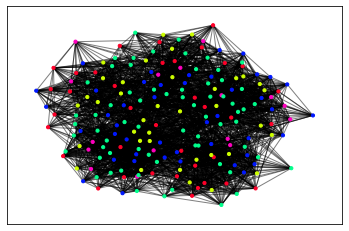

This is the community structure obtained using LLE in nxt-gem and spherical k-means:


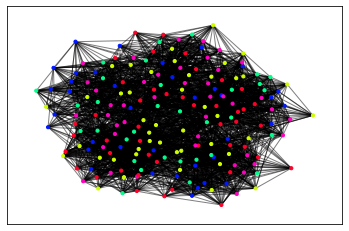

The NMI scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with Euclidean k-means:
 0.011362978413551054
The NMI scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with spherical k-means:
 0.018138825257731403
The ECS scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with Euclidean k-means:
 0.1921473900568034
The ECS scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with spherical k-means:
 0.19820479656093462


In [4]:
### Locally Linear Method from nxt-gem package
from gem.embedding.lle import LocallyLinearEmbedding


lle_model = LocallyLinearEmbedding(d=D)

lle_embd = lle_model.learn_embedding(graph=G, is_weighted=True, no_python=True)


lle_vec = [Vectors.dense(row) for row in lle_embd]
lle_prep = SparkSession.builder.getOrCreate().\
                createDataFrame([(vector,) for vector in lle_vec], ["embd"])

euclid_kmeans = KMeans(k=len(set(intrinsic_list)), featuresCol="embd")
cosine_kmeans = KMeans(k=len(set(intrinsic_list)), featuresCol="embd", distanceMeasure="cosine")
lle_euclid_model = euclid_kmeans.fit(lle_prep)
lle_cosine_model = cosine_kmeans.fit(lle_prep)

# Add the cluster assignment to the DataFrame
lle_euclid = lle_euclid_model.transform(lle_prep)
lle_cosine = lle_cosine_model.transform(lle_prep)

# Extract the cluster assignment and convert it to a list
lle_euclid_membership = lle_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
lle_cosine_membership = lle_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()

print("This is the community structure obtained using LLE in nxt-gem and Euclidean k-means:")
nx.draw_networkx_nodes(G,
              pos,
              node_size=10,
              cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
              node_color=list(lle_euclid_membership)
              )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
print("This is the community structure obtained using LLE in nxt-gem and spherical k-means:")
nx.draw_networkx_nodes(G,
        pos,
        node_size=10,
        cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
        node_color=list(lle_cosine_membership)
        )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()


print("The NMI scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with Euclidean k-means:\n", EE(intrinsic_list, intrinsic_clustering, lle_embd)[0])
print("The NMI scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with spherical k-means:\n", EE(intrinsic_list, intrinsic_clustering, lle_embd)[1])
print("The ECS scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with Euclidean k-means:\n", EE(intrinsic_list, intrinsic_clustering, lle_embd)[2])
print("The ECS scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with spherical k-means:\n", EE(intrinsic_list, intrinsic_clustering, lle_embd)[3])

Comparing the results of our LLE implementation with that of the LLE implementation in the nxt-gem package, we observe that our new LLE implementation produces more meaningful results.